In [1]:
import pandas as pd 
import numpy as np 
import pickle
import os 
from scipy.stats import norm

import time
from xgboost.sklearn import XGBRegressor
import matplotlib.pyplot as plt


In [2]:
def regional_closs(percentage_miss_strength):
    '''
    This function is developed for compute objective function corresponding to single set of value
    '''
    im_bin = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, float('inf')]
    retrof_ratio = {}
    prop = {}
    retrof_ds_ratio = {}
    retrof_ds_median = {}
    t = [int(p/0.05)*0.05 for p in percentage_miss_strength]
    percentage_miss_strength = t
    for i in range(1,9):
        temp = pd.DataFrame() 
        temp['Index'] = existing_prop['Index']
        temp['Xpeakstrength'] = np.divide(np.multiply(percentage_miss_strength[i-1], missing_strength['X Diff']) + peak_strength['Xpeakstrength'], peak_strength['Xpeakstrength']) + min_strength_retrofit_indicator['X'] * percentage_miss_strength[8]
        temp['Zpeakstrength'] = np.divide(np.multiply(percentage_miss_strength[i-1], missing_strength['Z Diff']) + peak_strength['Zpeakstrength'], peak_strength['Zpeakstrength']) + min_strength_retrofit_indicator['Z'] * percentage_miss_strength[8]
        retrof_ratio[i] = temp
        prop[i] = existing_prop.drop(['Xpeakstrength', 'Zpeakstrength'], axis = 1)
        prop[i]['Xpeakstrength'], prop[i]['Zpeakstrength'] = retrof_ratio[i]['Xpeakstrength'], retrof_ratio[i]['Zpeakstrength']

        retrof_ds_ratio[i] = pd.DataFrame(data = prop[i]['Index'])
        retrof_ds_ratio[i]['complete_ratio'] = retrof_complete_ratio.predict(prop[i].iloc[:,1:])
        # Compute retrofitted buildings damage state medians 
        retrof_ds_median[i] = pd.DataFrame(data = np.multiply(retrof_ds_ratio[i]['complete_ratio'],existing_ds['Complete']))
        retrof_ds_median[i].insert(0,'Index', retrof_ds_ratio[i]['Index'])

    closs, _ = compute_closs(sampled_building_info, building_loss, retrof_ds_median, sa_simulated, sa, im_bin)

    # Compute penalty term
    penalty_term = penalty(sampled_building_info, percentage_miss_strength, w, pd.DataFrame(index=[1,2,3,4,5,6,7,8,9]), retrof_percent_range, 'inverse')
    return - closs - penalty_term

def compute_closs(sampled_building_info, building_closs, building_dsm, design_sa, Sa_map, IM_bin):
    '''    
    This function is mainly used for computing regional earthquake losses given scenario
    sampled_building_info: assigned missing building information 
    building_loss: prototype archetype losses in each damage state 
    building_dsm: retrofitted prototype archetype damage state medians 
    Sa_map: ground shaking maps given scenario/event
    IM_bin: different retrofit strength is applied to different intensity bins
    '''

    buildings = pd.DataFrame(data = sampled_building_info['Index'])
    # Building collapse  at each location
    site_loss = buildings.merge(total_loss, how = 'left')

    # Compute probability of complete damage at each site given each shake map
    ds_prob_map = pd.DataFrame(np.zeros(Sa_map.shape))

    # Loop over all shake maps
    for k in range(8):
        for j in range(Sa_map.shape[1]):
            sub_Sa_map = Sa_map.loc[(design_sa.iloc[:,0] < IM_bin[k+1]) & (design_sa.iloc[:,0] >= IM_bin[k]), :].iloc[:,j]
            if sub_Sa_map.shape[0] == 0: 
                continue
            sub_building_map = buildings.loc[(design_sa.iloc[:,0] < IM_bin[k+1]) & (design_sa.iloc[:,0] >= IM_bin[k]),:]
            building_ds_median = sub_building_map.merge(building_dsm[k+1], how = 'left')
            ds_prob_map.loc[(design_sa.iloc[:,0] < IM_bin[k+1]) & (design_sa.iloc[:,0] >= IM_bin[k]), j] = norm.cdf(np.log(sub_Sa_map.astype('float64')), loc = np.log(building_ds_median.iloc[:,1]), scale = 0.6)
    collapse_prob = ds_prob_map.mean(axis = 1)

    regional_collapse_loss = np.multiply(collapse_prob,site_loss.iloc[:,1]).sum().sum()
    individual_loss =  sampled_building_info[['Latitude', 'Longitude']]
    individual_loss['Loss'] = np.multiply(collapse_prob,site_loss.iloc[:,1]).values
    return regional_collapse_loss, individual_loss

def penalty(sampled_building_info, ratios, w, penalty_df, retrof_limit, penalty_type):

    if penalty_type == 'linear':
        penalty_df['penalty'] = np.multiply(w , np.sqrt(ratios**2)) # In this case, w is a 4x1 list 

    elif penalty_type == 'inverse':
        temp = np.divide(np.sqrt(w), retrof_limit[1]-ratios+0.0000001)
        penalty_df['penalty'] = temp**2 # In this case, w is a single number

    elif penalty_type == 'single-building-cumulated-inverse':
        shape = [307, 769, 1762, 3381, 3244, 1358, 915, 306]
        temp = np.divide(np.sqrt(w), retrof_limit[1]-ratios+0.0000001)
        penalty_df['penalty'] = np.multiply(shape, temp**2) # In this case, w is a single number  
        
    elif penalty_type == 'quadratic-inverse':
        temp = np.divide(w, np.multiply(ratios-retrof_limit[0]+0.0000001,retrof_limit[1]-ratios+0.0000001))
        penalty_df['penalty'] = temp # In this case, w is a single number
 
    return penalty_df['penalty'].sum()

In [3]:
os.chdir(r'C:\Users\User\Desktop\FinalOptimization\XGBoostPipline\Models')
retrof_complete_ratio = pickle.load(open('Retrof_Complete_Ratio.pkl','rb'))

[11:31:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [4]:
# Sample unknown buildings 
def samplecase(OriginalData):
    InventoryData = OriginalData
    InventoryData = InventoryData.drop(columns = ['SMS'])
    for i in range(InventoryData.shape[0]):
        # Randomly assign number of stories
        if np.isnan(InventoryData.iloc[i,2]):
            InventoryData.iloc[i,2] = np.random.choice(np.arange(2, 4), p=[0.759, 0.241])
            
        # Randomly assign floor type          
        if pd.isnull(InventoryData.iloc[i,3]):
            InventoryData.iloc[i,3] = np.random.choice(np.arange(1, 5), p=[0.159, 0.011, 0.458, 0.372])
            
    
    
    InventoryData.loc[InventoryData['Story'] == 2,'Story'] = "2"
    InventoryData.loc[InventoryData['Story'] == 3,'Story'] = "3"
    
    InventoryData.loc[InventoryData['Type'] == 1,'Type'] = 'FWL1'
    InventoryData.loc[InventoryData['Type'] == 2,'Type'] = 'FWL2'
    InventoryData.loc[InventoryData['Type'] == 3,'Type'] = 'FWL3'
    InventoryData.loc[InventoryData['Type'] == 4,'Type'] = 'FWL4'
    
    InventoryData.loc[InventoryData['Type'] == 'FWL1','Type'] = 'L1'
    InventoryData.loc[InventoryData['Type'] == 'FWL2','Type'] = 'L2'
    InventoryData.loc[InventoryData['Type'] == 'FWL3','Type'] = 'L3'
    InventoryData.loc[InventoryData['Type'] == 'FWL4','Type'] = 'L4'
    
#     Randomly assign material type 
    mat = np.random.choice(np.arange(1, 3), size = InventoryData.shape[0], p=[0.5, 0.5])
    InventoryData['Material'] = mat
    
    InventoryData.loc[InventoryData['Material'] == 1,'Material'] = 'GWB'
    InventoryData.loc[InventoryData['Material'] == 2,'Material'] = 'HWS'
    
#     Randomly assign dimension 
    dim = np.random.choice(np.arange(1, 3), size = InventoryData.shape[0], p=[0.5, 0.5])
    InventoryData['Dimension'] = dim
    
#     Assign floor type
    InventoryData.loc[(InventoryData['Type'] == 'L1') & (InventoryData['Dimension'] == 1),'Dimension'] = '60X30'
    InventoryData.loc[(InventoryData['Type'] == 'L1') & (InventoryData['Dimension'] == 2),'Dimension'] = '100X30'
    
    InventoryData.loc[(InventoryData['Type'] == 'L1') & (InventoryData['Dimension'] == '60X30') 
                      & (InventoryData['Story'] == '2'),'Area'] = 60*30*2
    InventoryData.loc[(InventoryData['Type'] == 'L1') & (InventoryData['Dimension'] == '60X30') 
                      & (InventoryData['Story'] == '3'),'Area'] = 60*30*3
    InventoryData.loc[(InventoryData['Type'] == 'L1') & (InventoryData['Dimension'] == '100X30') 
                      & (InventoryData['Story'] == '2'),'Area'] = 100*30*2
    InventoryData.loc[(InventoryData['Type'] == 'L1') & (InventoryData['Dimension'] == '100X30') 
                      & (InventoryData['Story'] == '3'),'Area'] = 100*30*3
    
    InventoryData.loc[(InventoryData['Type'] == 'L2') & (InventoryData['Dimension'] == 1),'Dimension'] = '60X50'
    InventoryData.loc[(InventoryData['Type'] == 'L2') & (InventoryData['Dimension'] == 2),'Dimension'] = '100X50'
    
    InventoryData.loc[(InventoryData['Type'] == 'L2') & (InventoryData['Dimension'] == '60X50') 
                      & (InventoryData['Story'] == '2'),'Area'] = 60*50*2
    InventoryData.loc[(InventoryData['Type'] == 'L2') & (InventoryData['Dimension'] == '60X50') 
                      & (InventoryData['Story'] == '3'),'Area'] = 60*50*3
    InventoryData.loc[(InventoryData['Type'] == 'L2') & (InventoryData['Dimension'] == '100X50') 
                      & (InventoryData['Story'] == '2'),'Area'] = 100*50*2
    InventoryData.loc[(InventoryData['Type'] == 'L2') & (InventoryData['Dimension'] == '100X50') 
                      & (InventoryData['Story'] == '3'),'Area'] = 100*50*3
    
    InventoryData.loc[(InventoryData['Type'] == 'L3') & (InventoryData['Dimension'] == 1),'Dimension'] = '50X30'
    InventoryData.loc[(InventoryData['Type'] == 'L3') & (InventoryData['Dimension'] == 2),'Dimension'] = '80X30'
    
    InventoryData.loc[(InventoryData['Type'] == 'L3') & (InventoryData['Dimension'] == '50X30') 
                      & (InventoryData['Story'] == '2'),'Area'] = 50*30*2
    InventoryData.loc[(InventoryData['Type'] == 'L3') & (InventoryData['Dimension'] == '50X30') 
                      & (InventoryData['Story'] == '3'),'Area'] = 50*30*3
    InventoryData.loc[(InventoryData['Type'] == 'L3') & (InventoryData['Dimension'] == '80X30') 
                      & (InventoryData['Story'] == '2'),'Area'] = 80*30*2
    InventoryData.loc[(InventoryData['Type'] == 'L3') & (InventoryData['Dimension'] == '80X30') 
                      & (InventoryData['Story'] == '3'),'Area'] = 80*30*3
    
    InventoryData.loc[(InventoryData['Type'] == 'L4') & (InventoryData['Dimension'] == 1),'Dimension'] = '60X50'
    InventoryData.loc[(InventoryData['Type'] == 'L4') & (InventoryData['Dimension'] == 2),'Dimension'] = '100X50'
    
    InventoryData.loc[(InventoryData['Type'] == 'L4') & (InventoryData['Dimension'] == '60X50') 
                      & (InventoryData['Story'] == '2'),'Area'] = 60*50*2
    InventoryData.loc[(InventoryData['Type'] == 'L4') & (InventoryData['Dimension'] == '60X50') 
                      & (InventoryData['Story'] == '3'),'Area'] = 60*50*3
    InventoryData.loc[(InventoryData['Type'] == 'L4') & (InventoryData['Dimension'] == '100X50') 
                      & (InventoryData['Story'] == '2'),'Area'] = 100*50*2
    InventoryData.loc[(InventoryData['Type'] == 'L4') & (InventoryData['Dimension'] == '100X50') 
                      & (InventoryData['Story'] == '3'),'Area'] = 100*50*3

    InventoryData['Index'] = InventoryData['Type'] + '-' + InventoryData['Story'] + 'S-' + InventoryData['Dimension'].astype('str') + '-' + InventoryData['Material']
    
    #     Randomly assign repair cost
    InventoryData['Num_Units'] = (np.round(InventoryData['Area'].values/1000)).astype(int)
    Median_Cost = np.interp(InventoryData['Num_Units'],[4,30],[6250,4000])
    
    InventoryData['RepairCost'] = np.random.normal(Median_Cost,400)*InventoryData['Num_Units']
    InventoryData['SMS'] = OriginalData['SMS']
    return InventoryData

In [5]:
os.chdir(r'C:\Users\User\Desktop\FinalOptimization\Optimization_MultiScenarios')
# Read original building info
OriginalBuildingInfo = pd.read_csv('LA Inventory.csv')

# Random assign unknown buildings
# sampled_building_info = samplecase(OriginalBuildingInfo)
sampled_building_info = pd.read_csv(r'C:\Users\User\Desktop\temp.csv')

# Optimize for the M7.1 senario
sa_simulated = pd.read_csv('DBEResults/Sa_simulated_real.csv', header = None)

# Read existing building damage state
existing_ds = pd.read_csv('building_ds.csv')

# Read minnimum strength retrofit
min_strength_retrofit_indicator = pd.read_csv('min_strength_retrofit.csv')

# Read existing building properties and pushover 
existing_prop = pd.read_csv('existing_property.csv')

# Read building losses
total_loss = pd.read_csv('complete_loss.csv')

# Use complete loss as criteria: complete loss = building collapse loss + fatality loss ($2 million per fatality)
building_loss = pd.read_csv('complete_loss.csv') 

# Read retrofit upper limit, which corresponding to NON SWOF building peak strength
retrof_upper_limit = pd.read_csv('UpperLimit.csv')

# Read missing strength
missing_strength = pd.read_csv('building_miss_strength.csv')

# Read existing building damage state medians
existing_ds = pd.read_csv('building_ds.csv')

# Existing pushover peak strength
peak_strength = pd.DataFrame()
peak_strength['Index'] = existing_prop['Index']
peak_strength['Xpeakstrength'] = np.multiply(existing_prop['SeismicWeight'], existing_prop['Xpeakstrength'])
peak_strength['Zpeakstrength'] = np.multiply(existing_prop['SeismicWeight'], existing_prop['Zpeakstrength'])

In [26]:
# Read in and stack 20 representative scenarios 
ids = [98,635,969,2177,3110,4393,4520,5278,5575,5675,5846,6403,6965,7396,7572,7604,7681,7718,8033,8294]
sa = pd.DataFrame(index=range(12060))
for i in ids:
    os.chdir(r'D:\Google Drive\Research\Ph.D. Topic Research\Cost_Benefit\UCERF2_Event_Processed_Data\Clustered Events\Event%i'%i)
    temp = pd.read_csv('sa_simulated.csv', index_col=0)
    sa = pd.concat([sa, temp], axis = 1)


## Collapse Loss Optimization

In [28]:
from bayes_opt import BayesianOptimization

def obj_func(a,b,c,d,e,f,g,h,i):
    p = [a,b,c,d,e,f,g,h,i]
    return regional_closs(p)
retrof_percent_range = np.array([[0]*9, [1,1,1,1,1,1,1,1,0.4]])
pbounds = {'a':(0, 1), 'b':(0, 1), 'c':(0, 1), 'd':(0, 1), 'e':(0, 1), 'f':(0, 1), 'g':(0, 1), 'h':(0, 1), 'i': (0, 0.4)}

In [29]:
w = 1000000
x_best  = []

optimizer = BayesianOptimization(f = obj_func,
                                pbounds = pbounds)
# optimizer.probe(params={'a':1, 'b':1, 'c':1, 'd':1, 'e':1, 'f':1, 'g':1, 'h':1, 'i': 0.4}, lazy=True)
optimizer.probe(params={'a':0.1, 'b':0.1, 'c':0.1, 'd':0.1, 'e':0.1, 'f':0.1, 'g':0.1, 'h':0.1, 'i':0.2}, lazy=True)
optimizer.probe(params={'a':0.2, 'b':0.2, 'c':0.2, 'd':0.2, 'e':0.2, 'f':0.2, 'g':0.2, 'h':0.2, 'i':0.2}, lazy=True)
optimizer.probe(params={'a':0.3, 'b':0.3, 'c':0.3, 'd':0.3, 'e':0.3, 'f':0.3, 'g':0.3, 'h':0.3, 'i':0.2}, lazy=True)
optimizer.probe(params={'a':0.4, 'b':0.4, 'c':0.4, 'd':0.4, 'e':0.4, 'f':0.4, 'g':0.4, 'h':0.4, 'i':0.2}, lazy=True)
optimizer.probe(params={'a':0.5, 'b':0.5, 'c':0.5, 'd':0.5, 'e':0.5, 'f':0.5, 'g':0.5, 'h':0.5, 'i':0.3}, lazy=True)

optimizer.maximize(init_points = 100, n_iter = 50)
x_best.append(optimizer.max['params'])

|   iter    |  target   |     a     |     b     |     c     |     d     |     e     |     f     |     g     |     h     |     i     |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        | -4.5e+20  |  1.0      |  1.0      |  1.0      |  1.0      |  1.0      |  1.0      |  1.0      |  1.0      |  0.4      |
|  2        | -2.621e+0 |  0.1      |  0.1      |  0.1      |  0.1      |  0.1      |  0.1      |  0.1      |  0.1      |  0.1      |
|  3        | -2.587e+0 |  0.2      |  0.2      |  0.2      |  0.2      |  0.2      |  0.2      |  0.2      |  0.2      |  0.1      |


KeyboardInterrupt: 

In [29]:
optimizer.max['params'].values()


dict_values([0.3101596163635364, 0.6503973317292239, 0.9262336250649947, 0.6688325716498433, 0.41770691506414753, 0.6012234292837778, 0.7877705276408278, 0.5730370411244743, 0.36448808831060536])

## Post Processing

In [5]:
# Read the results from Hoffman 
import seaborn as sns

# read-in all results
BaseDirectory = r'C:\Users\User\Desktop\FinalOptimization\Optimization_AllArchetypes\WeightSensitivity'
os.chdir(BaseDirectory + r'\Results\2thWeight')

x_bests = pd.DataFrame(columns=[0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5], index = range(200))

for i in range(200):
    results = pd.read_csv('%ithOptimization.csv'%i)
    t = [int(p/0.05)*0.05 for p in results.values[0][1:]]
    x_bests.iloc[i-1,:] = t

In [6]:
np.median(x_bests, axis = 0)

array([0.4, 0.475, 0.7000000000000001, 0.775, 0.75, 0.65, 0.55, 0.45,
       0.30000000000000004], dtype=object)

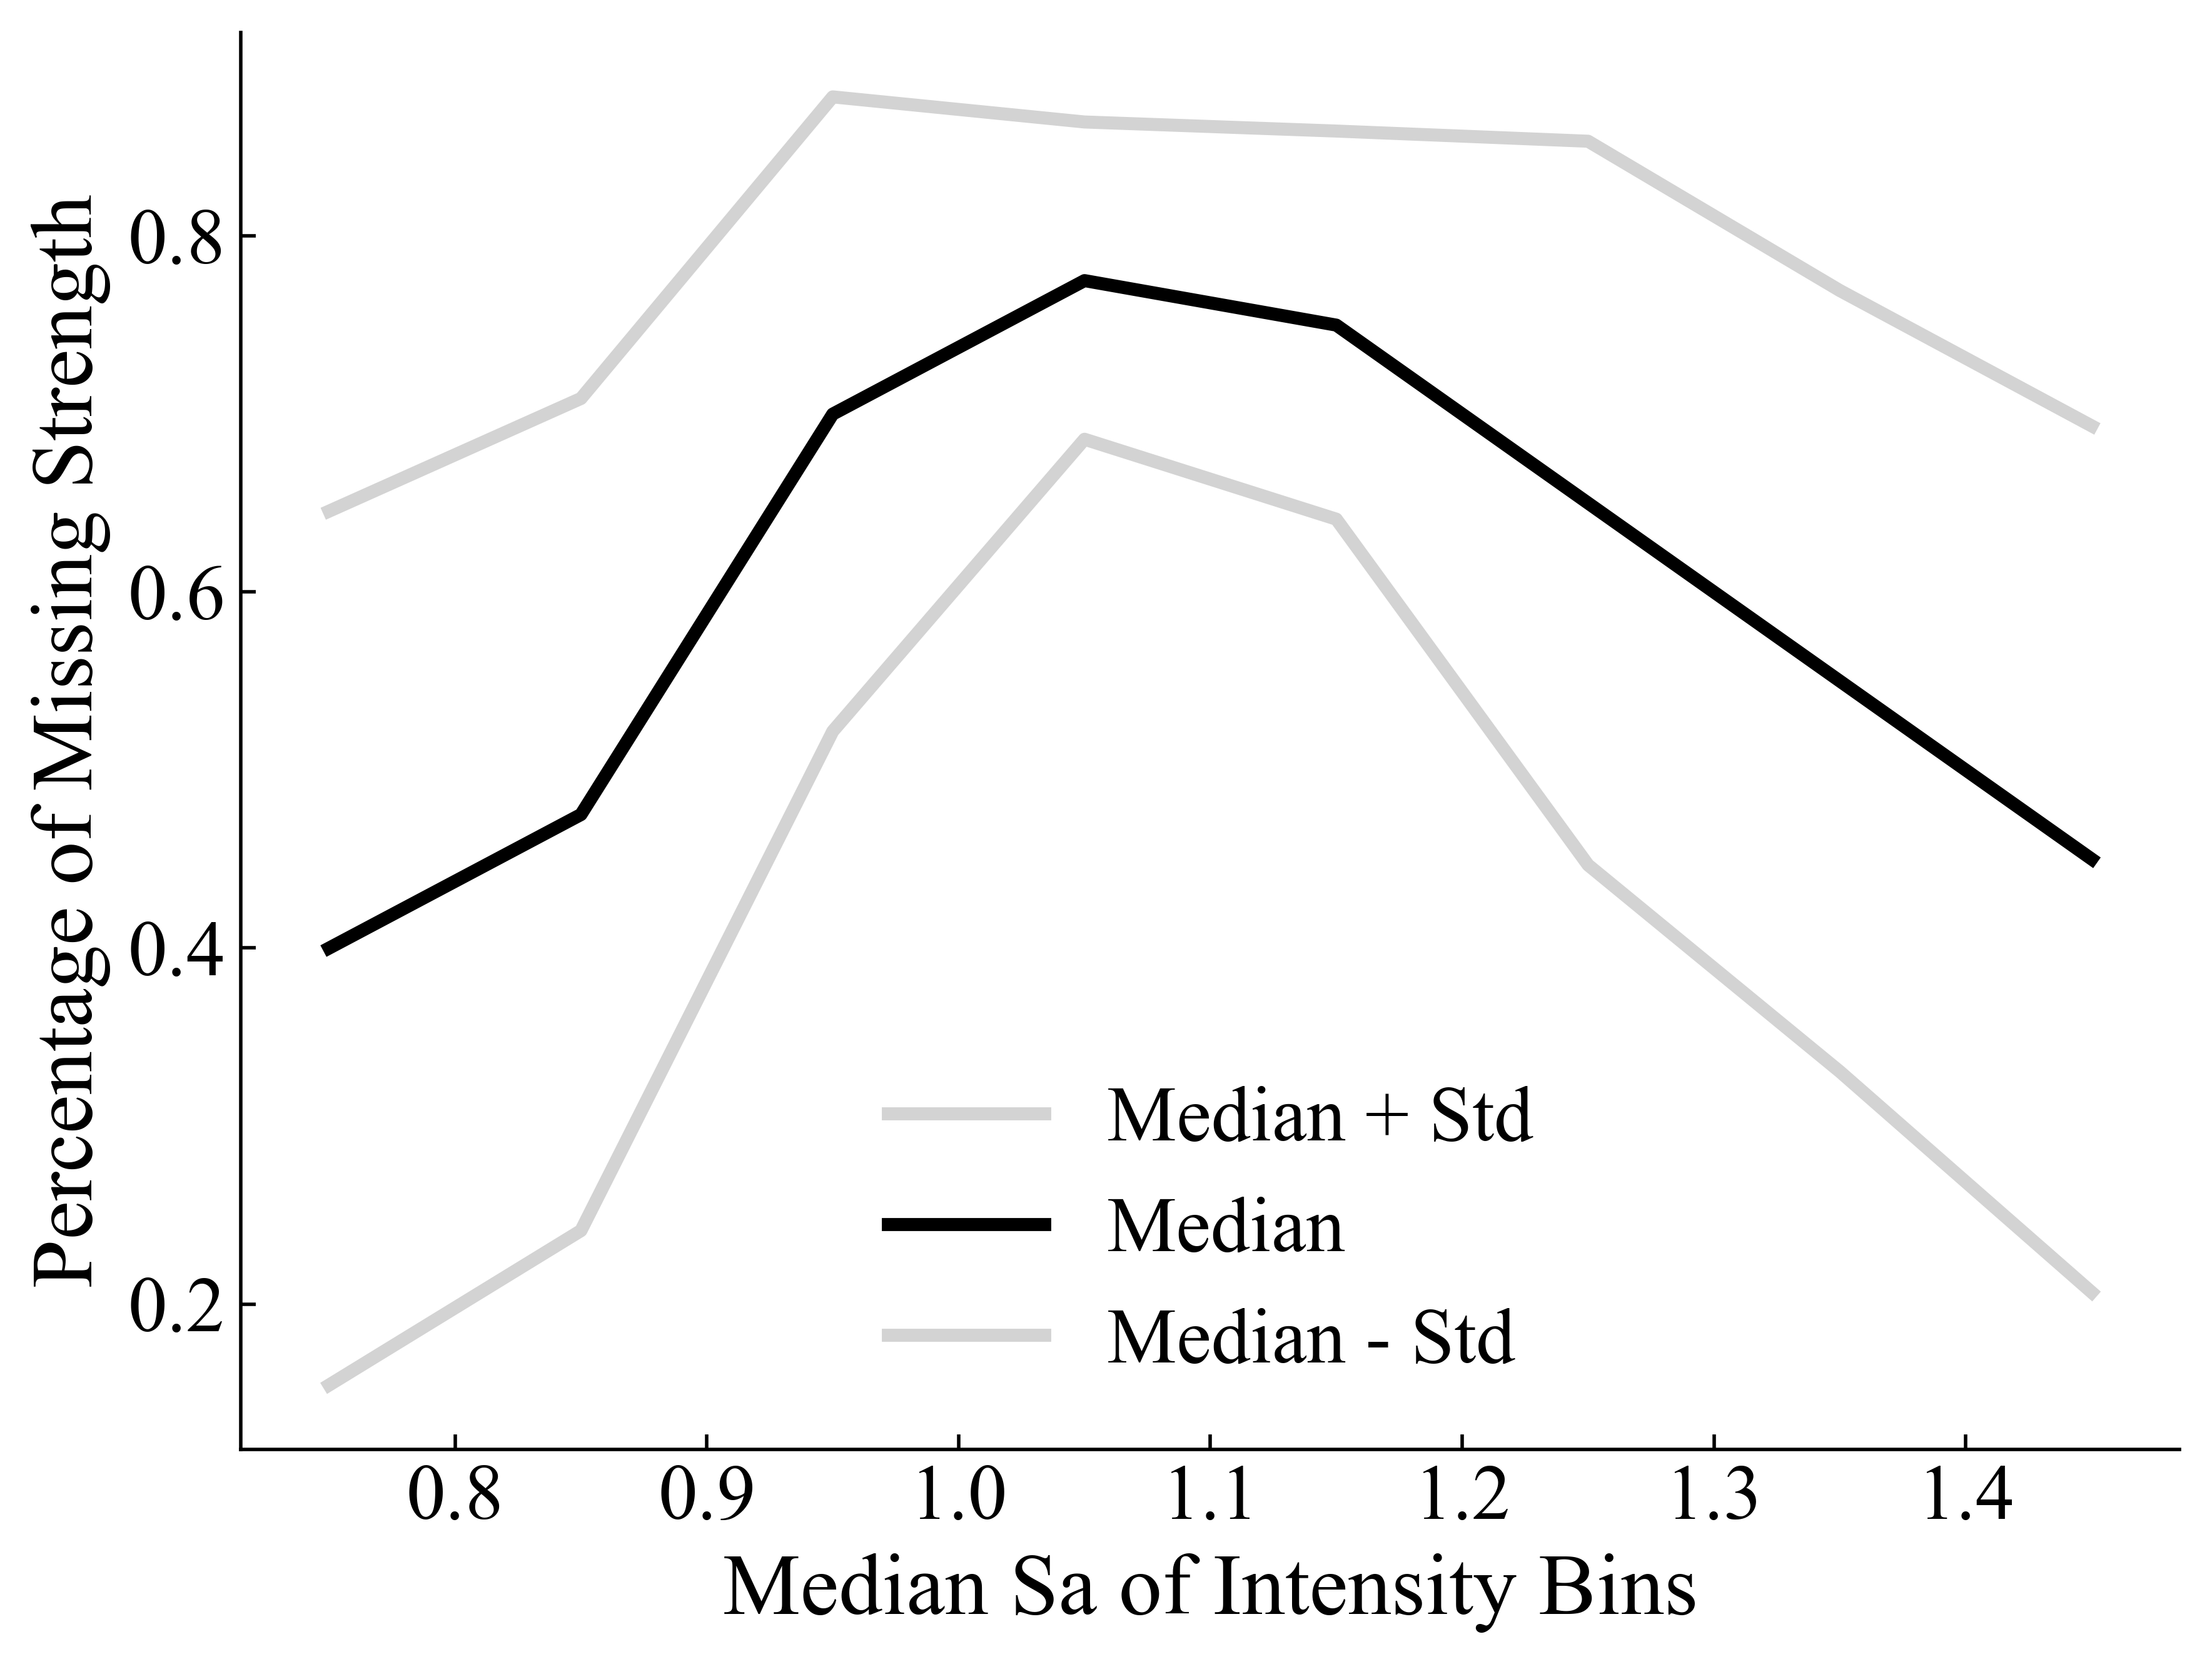

In [32]:
fig, ax = plt.subplots(figsize=(8,6), dpi=500)
font = {'fontname':'Times New Roman', 'size' : 20}

# for i in range(200):
#     ax.scatter([0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.35, 1.45], list(x_bests.iloc[i,:].values), color='grey')
ax.plot([0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.35, 1.45], (np.median(x_bests, axis = 0)+np.sqrt(np.var(x_bests))).values[0:8], color = 'lightgrey', linewidth = 3, label = 'Median + Std')
ax.plot([0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.35, 1.45], np.median(x_bests, axis = 0)[0:8], color = 'black', linewidth = 3, label = 'Median')
ax.plot([0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.35, 1.45], (np.median(x_bests, axis = 0)-np.sqrt(np.var(x_bests))).values[0:8], color = 'lightgrey', linewidth = 3, label = 'Median - Std')
plt.xlabel('Median Sa of Intensity Bins', **font)
plt.ylabel('Percentage of Missing Strength', **font)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
plt.xticks(fontname = 'Times New Roman', fontsize = 18)
plt.yticks(fontname = 'Times New Roman', fontsize = 18)
plt.locator_params(axis='y', nbins=6)
plt.legend(frameon = False, prop =  {"family":'Times New Roman', "size":18})
sns.despine()

In [7]:
def algorithm_added_strength(percentage_miss_strength, sampled_building_info, Sa_map, miss_strength, peak_strength, IM_bin):
    '''
    This function is developed for compute the total strength added by algorithm
    '''
    buildings = pd.DataFrame(data = sampled_building_info['Index'])
    cost_map = pd.DataFrame(np.zeros(Sa_map.shape))
    for k in range(8):
        temp = pd.DataFrame() 
        temp['Index'] = existing_prop['Index']
        temp['Total Force'] = np.multiply(percentage_miss_strength[k], miss_strength['X Diff']) + np.multiply(percentage_miss_strength[k], miss_strength['Z Diff']) + np.multiply(percentage_miss_strength[8], peak_strength['X'] + peak_strength['Z'])
        for j in range(Sa_map.shape[1]):
            sub_Sa_map = Sa_map.loc[(Sa_map.iloc[:,j] < IM_bin[k+1]) & (Sa_map.iloc[:,j] >= IM_bin[k]), :].iloc[:,j]
            if sub_Sa_map.shape[0] == 0: 
                continue
            sub_building_map = buildings.loc[(Sa_map.iloc[:,j] < IM_bin[k+1]) & (Sa_map.iloc[:,j] >= IM_bin[k]),:]
            building_cost = sub_building_map.merge(temp)
            cost_map.loc[(Sa_map.iloc[:,j] < IM_bin[k+1]) & (Sa_map.iloc[:,j] >= IM_bin[k]), j] = building_cost.iloc[:,1].values

    total_cost =  cost_map.mean(axis = 1).sum()
    return total_cost

In [24]:
im_bin = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, float('inf')]
retrof_ratio = {}
prop = {}
retrof_ds_ratio = {}
retrof_ds_median = {}
percentage_miss_strength = np.median(x_bests, axis = 0)
min_strength_retrof_peakstrength = pd.read_csv(r'C:\Users\User\Desktop\FinalOptimization\Optimization_AllArchetypes\min_strength_pushoverstrength.csv')
t = [int(p/0.05)*0.05 for p in percentage_miss_strength]
percentage_miss_strength = t
for i in range(1,9):
    temp = pd.DataFrame() 
    temp['Index'] = existing_prop['Index']
    temp['Xpeakstrength'] = np.divide(np.multiply(percentage_miss_strength[i-1], missing_strength['X Diff']) + peak_strength['Xpeakstrength'], peak_strength['Xpeakstrength']) + percentage_miss_strength[8] * min_strength_retrofit_indicator['X']
    temp['Zpeakstrength'] = np.divide(np.multiply(percentage_miss_strength[i-1], missing_strength['Z Diff']) + peak_strength['Zpeakstrength'], peak_strength['Zpeakstrength']) + percentage_miss_strength[8] * min_strength_retrofit_indicator['Z']
    retrof_ratio[i] = temp
    prop[i] = existing_prop.drop(columns=['Xpeakstrength', 'Zpeakstrength'])
    prop[i]['Xpeakstrength'], prop[i]['Zpeakstrength'] = retrof_ratio[i]['Xpeakstrength'], retrof_ratio[i]['Zpeakstrength']

    retrof_ds_ratio[i] = pd.DataFrame(data = prop[i]['Index'])
    retrof_ds_ratio[i]['complete_ratio'] = retrof_complete_ratio.predict(prop[i].iloc[:,1:])
    # Compute retrofitted buildings damage state medians 
    retrof_ds_median[i] = pd.DataFrame(data = np.multiply(retrof_ds_ratio[i]['complete_ratio'],existing_ds['Complete']))
    retrof_ds_median[i].insert(0,'Index', retrof_ds_ratio[i]['Index'])

Algorithm_closs, Algorithm_closs_individual = compute_closs(sampled_building_info, building_loss, retrof_ds_median, sa_simulated, im_bin)
Algorithm_cost =  algorithm_added_strength(percentage_miss_strength, sampled_building_info, sa_simulated, missing_strength,min_strength_retrof_peakstrength, im_bin)

# Ordinance Performance Evaluation

In [9]:
def actual_building_loss(sampled_building_info, building_loss, building_dsm, Sa_map):
    '''    
    This function is mainly used for computing regional earthquake losses given scenario
    sampled_building_info: assigned missing building information 
    building_loss: prototype archetype losses in each damage state 
    building_dsm: retrofitted prototype archetype damage state medians 
    Sa_map: ground shaking maps given scenario/event
    '''
    buildings = pd.DataFrame(data = sampled_building_info['Index'])
    # Building collapse  at each location
    site_loss = buildings.merge(building_loss, how = 'left')

    # Building damage state median at each location 
    building_ds_median = buildings.merge(building_dsm, how = 'left')

    # Compute probability of complete damage at each site given each shake map
    ds_prob_map = pd.DataFrame(np.zeros(Sa_map.shape))
    # Loop over all shake maps
    for j in range(Sa_map.shape[1]):
        ds_prob_map.iloc[:,j] = norm.cdf(np.log(Sa_map.iloc[:,j]), loc = np.log(building_ds_median.iloc[:,1]), scale = 0.6)
    collapse_prob = ds_prob_map.mean(axis = 1)

    portfolio_loss = np.multiply(collapse_prob,site_loss.iloc[:,1]).sum().sum()
    individual_loss =  sampled_building_info[['Latitude', 'Longitude']]
    individual_loss['Loss'] = np.multiply(collapse_prob,site_loss.iloc[:,1]).values
    return portfolio_loss, individual_loss

def ordinance_added_strength(sampled_building_info, added_strength):
    buildings = pd.DataFrame(data = sampled_building_info['Index'])
    # Building collapse  at each location
    site_cost = buildings.merge(added_strength, how = 'left')
    return site_cost.iloc[:,1].sum()


In [10]:
Existing_closs, Existing_closs_individual = actual_building_loss(sampled_building_info, total_loss, existing_ds, sa_simulated)
Algorithm_reduction = 1-Algorithm_closs/Existing_closs 
print('Algorithm reduces the loss by %.4f'%Algorithm_reduction)

Algorithm reduces the loss by 0.2076


In [11]:
ordinance_ds = pd.read_csv(r'C:\Users\User\Desktop\FinalOptimization\OrdinancePerformance\CollapseMedian.csv')
ordinance_retrof_strength = pd.read_csv(r'C:\Users\User\Desktop\FinalOptimization\OrdinancePerformance\OrdinanceStrengthInc.csv')
SMS_bin = [0, 1.601, 1.8, 1.995, 2.2, 2.4, 2.6, 2.801, 3.0]
Ordinance_closs = 0
Ordinance_cost = 0
Ordinance_closs_individual = pd.DataFrame(columns=['Index','Loss'])
for i in range(8):
    sub_building_map = sampled_building_info.loc[(sampled_building_info['SMS'] <= SMS_bin[i+1]) & (sampled_building_info['SMS'] > SMS_bin[i]),:]
    sub_sa_map = sa_simulated.loc[(sampled_building_info['SMS'] <= SMS_bin[i+1]) & (sampled_building_info['SMS'] > SMS_bin[i]),:]
    or_dsm = ordinance_ds[['Index','%i'%i]]
    sub_building_map_closs, sub_building_individual_loss = actual_building_loss(sub_building_map, total_loss, or_dsm, sub_sa_map)
    Ordinance_closs_individual = Ordinance_closs_individual.append(sub_building_individual_loss)
    Ordinance_closs += sub_building_map_closs
    Ordinance_cost += ordinance_added_strength(sub_building_map, ordinance_retrof_strength[['Index','%i'%i]])


Ordinance_reduction = 1-Ordinance_closs/Existing_closs 
print('Ordinance reduces the loss by %.4f'%Ordinance_reduction)
print('Algorithm uses %.4f strength of Ordinance retrofit'%(Algorithm_cost/Ordinance_cost))

Ordinance reduces the loss by 0.2323
Algorithm uses 0.8061 strength of Ordinance retrofit


In [34]:
Algorithm_closs_individual.to_csv(r'C:\Users\User\Desktop\FinalOptimization\Optimization_AllArchetypes\LossMap\Algorithm.csv')
Ordinance_closs_individual.to_csv(r'C:\Users\User\Desktop\FinalOptimization\Optimization_AllArchetypes\LossMap\Ordinance.csv')
Existing_closs_individual.to_csv(r'C:\Users\User\Desktop\FinalOptimization\Optimization_AllArchetypes\LossMap\Existing.csv')

In [38]:
#Perform evaluation for 100 sampled building archetype distribution 
A_Loss, A_Cost = [], []
O_Loss, O_Cost = [], []
E_Loss = []

for g in range(100):
    sampled_building_info = samplecase(OriginalBuildingInfo)

    im_bin = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, float('inf')]
    retrof_ratio = {}
    prop = {}
    retrof_ds_ratio = {}
    retrof_ds_median = {}
    percentage_miss_strength = np.median(x_bests, axis = 0)
    min_strength_retrof_peakstrength = pd.read_csv(r'C:\Users\User\Desktop\FinalOptimization\Optimization_AllArchetypes\min_strength_pushoverstrength.csv')
    t = [int(p/0.05)*0.05 for p in percentage_miss_strength]
    percentage_miss_strength = t
    for i in range(1,9):
        temp = pd.DataFrame() 
        temp['Index'] = existing_prop['Index']
        temp['Xpeakstrength'] = np.divide(np.multiply(percentage_miss_strength[i-1], missing_strength['X Diff']) + peak_strength['Xpeakstrength'], peak_strength['Xpeakstrength']) + percentage_miss_strength[8] * min_strength_retrofit_indicator['X']
        temp['Zpeakstrength'] = np.divide(np.multiply(percentage_miss_strength[i-1], missing_strength['Z Diff']) + peak_strength['Zpeakstrength'], peak_strength['Zpeakstrength']) + percentage_miss_strength[8] * min_strength_retrofit_indicator['Z']
        retrof_ratio[i] = temp
        prop[i] = existing_prop.drop(columns=['Xpeakstrength', 'Zpeakstrength'])
        prop[i]['Xpeakstrength'], prop[i]['Zpeakstrength'] = retrof_ratio[i]['Xpeakstrength'], retrof_ratio[i]['Zpeakstrength']

        retrof_ds_ratio[i] = pd.DataFrame(data = prop[i]['Index'])
        retrof_ds_ratio[i]['complete_ratio'] = retrof_complete_ratio.predict(prop[i].iloc[:,1:])
        # Compute retrofitted buildings damage state medians 
        retrof_ds_median[i] = pd.DataFrame(data = np.multiply(retrof_ds_ratio[i]['complete_ratio'],existing_ds['Complete']))
        retrof_ds_median[i].insert(0,'Index', retrof_ds_ratio[i]['Index'])

    Algorithm_closs, Algorithm_closs_individual = compute_closs(sampled_building_info, building_loss, retrof_ds_median, sa_simulated, im_bin)
    Algorithm_cost =  algorithm_added_strength(percentage_miss_strength, sampled_building_info, sa_simulated, missing_strength,min_strength_retrof_peakstrength, im_bin)
    A_Loss.append(Algorithm_closs)
    A_Cost.append(Algorithm_cost)

    Existing_closs, _ = actual_building_loss(sampled_building_info, total_loss, existing_ds, sa_simulated)
    E_Loss.append(Existing_closs)

    Ordinance_closs = 0
    Ordinance_cost = 0
    for i in range(8):
        sub_building_map = sampled_building_info.loc[(sampled_building_info['SMS'] <= SMS_bin[i+1]) & (sampled_building_info['SMS'] > SMS_bin[i]),:]
        sub_sa_map = sa_simulated.loc[(sampled_building_info['SMS'] <= SMS_bin[i+1]) & (sampled_building_info['SMS'] > SMS_bin[i]),:]
        or_dsm = ordinance_ds[['Index','%i'%i]]
        sub_building_map_closs, _ = actual_building_loss(sub_building_map, total_loss, or_dsm, sub_sa_map)
        Ordinance_closs += sub_building_map_closs
        Ordinance_cost += ordinance_added_strength(sub_building_map, ordinance_retrof_strength[['Index','%i'%i]])

    O_Loss.append(Ordinance_closs)
    O_Cost.append(Ordinance_cost)

In [39]:
print(np.mean(A_Cost)/np.mean(O_Cost))
print(np.mean(A_Loss)/np.mean(O_Loss))
print((np.mean(A_Loss)-np.mean(E_Loss))/(np.mean(O_Loss)-np.mean(E_Loss)))

4.765020828596307
19.80697873118936
0.08717677013136971


# Sensitivity Results


In [37]:
W = [0, 100000, 1000000, 2000000, 3000000, 5000000, 8000000, 10000000, 15000000, 20000000]
BaseDirectory = r'C:\Users\User\Desktop\FinalOptimization\Optimization_AllArchetypes\WeightSensitivity'

median_bests = []
for j in range(10):

    # read-in all results
    os.chdir(BaseDirectory + r'\Results\%ithWeight'%j)

    x_bests = pd.DataFrame(columns=[0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5], index = range(200))

    for i in range(200):
        results = pd.read_csv('%ithOptimization.csv'%i)
        t = [int(p/0.05)*0.05 for p in results.values[0][1:]]
        x_bests.iloc[i-1,:] = t

    median_bests.append(np.median(x_bests, axis = 0))


In [38]:
algorithm_cost_sens, algorithm_loss_sens = [], []

for x in median_bests:
    im_bin = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, float('inf')]
    retrof_ratio = {}
    prop = {}
    retrof_ds_ratio = {}
    retrof_ds_median = {}
    percentage_miss_strength = np.median(x_bests, axis = 0)
    min_strength_retrof_peakstrength = pd.read_csv(r'C:\Users\User\Desktop\FinalOptimization\Optimization_AllArchetypes\min_strength_pushoverstrength.csv')
    percentage_miss_strength = x
    for i in range(1,9):
        temp = pd.DataFrame() 
        temp['Index'] = existing_prop['Index']
        temp['Xpeakstrength'] = np.divide(np.multiply(percentage_miss_strength[i-1], missing_strength['X Diff']) + peak_strength['Xpeakstrength'], peak_strength['Xpeakstrength']) + percentage_miss_strength[8] * min_strength_retrofit_indicator['X']
        temp['Zpeakstrength'] = np.divide(np.multiply(percentage_miss_strength[i-1], missing_strength['Z Diff']) + peak_strength['Zpeakstrength'], peak_strength['Zpeakstrength']) + percentage_miss_strength[8] * min_strength_retrofit_indicator['Z']
        retrof_ratio[i] = temp
        prop[i] = existing_prop.drop(columns=['Xpeakstrength', 'Zpeakstrength'])
        prop[i]['Xpeakstrength'], prop[i]['Zpeakstrength'] = retrof_ratio[i]['Xpeakstrength'], retrof_ratio[i]['Zpeakstrength']

        retrof_ds_ratio[i] = pd.DataFrame(data = prop[i]['Index'])
        retrof_ds_ratio[i]['complete_ratio'] = retrof_complete_ratio.predict(prop[i].iloc[:,1:])
        # Compute retrofitted buildings damage state medians 
        retrof_ds_median[i] = pd.DataFrame(data = np.multiply(retrof_ds_ratio[i]['complete_ratio'],existing_ds['Complete']))
        retrof_ds_median[i].insert(0,'Index', retrof_ds_ratio[i]['Index'])

    Algorithm_closs_s, _ = compute_closs(sampled_building_info, building_loss, retrof_ds_median, sa_simulated, im_bin)
    Algorithm_cost_s =  algorithm_added_strength(percentage_miss_strength, sampled_building_info, sa_simulated, missing_strength,min_strength_retrof_peakstrength, im_bin)

    algorithm_cost_sens.append(Algorithm_cost_s)
    algorithm_loss_sens.append(Algorithm_closs_s)
Existing_closs, Existing_closs_individual = actual_building_loss(sampled_building_info, total_loss, existing_ds, sa_simulated)

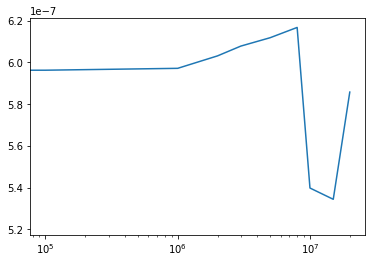

In [23]:

r = [1-algorithm_loss_sens[i]/Existing_closs for i in range(len(W))]
e = [x/y for x, y in zip(r, algorithm_cost_sens)]

plt.plot(W, e)
plt.xscale('log')



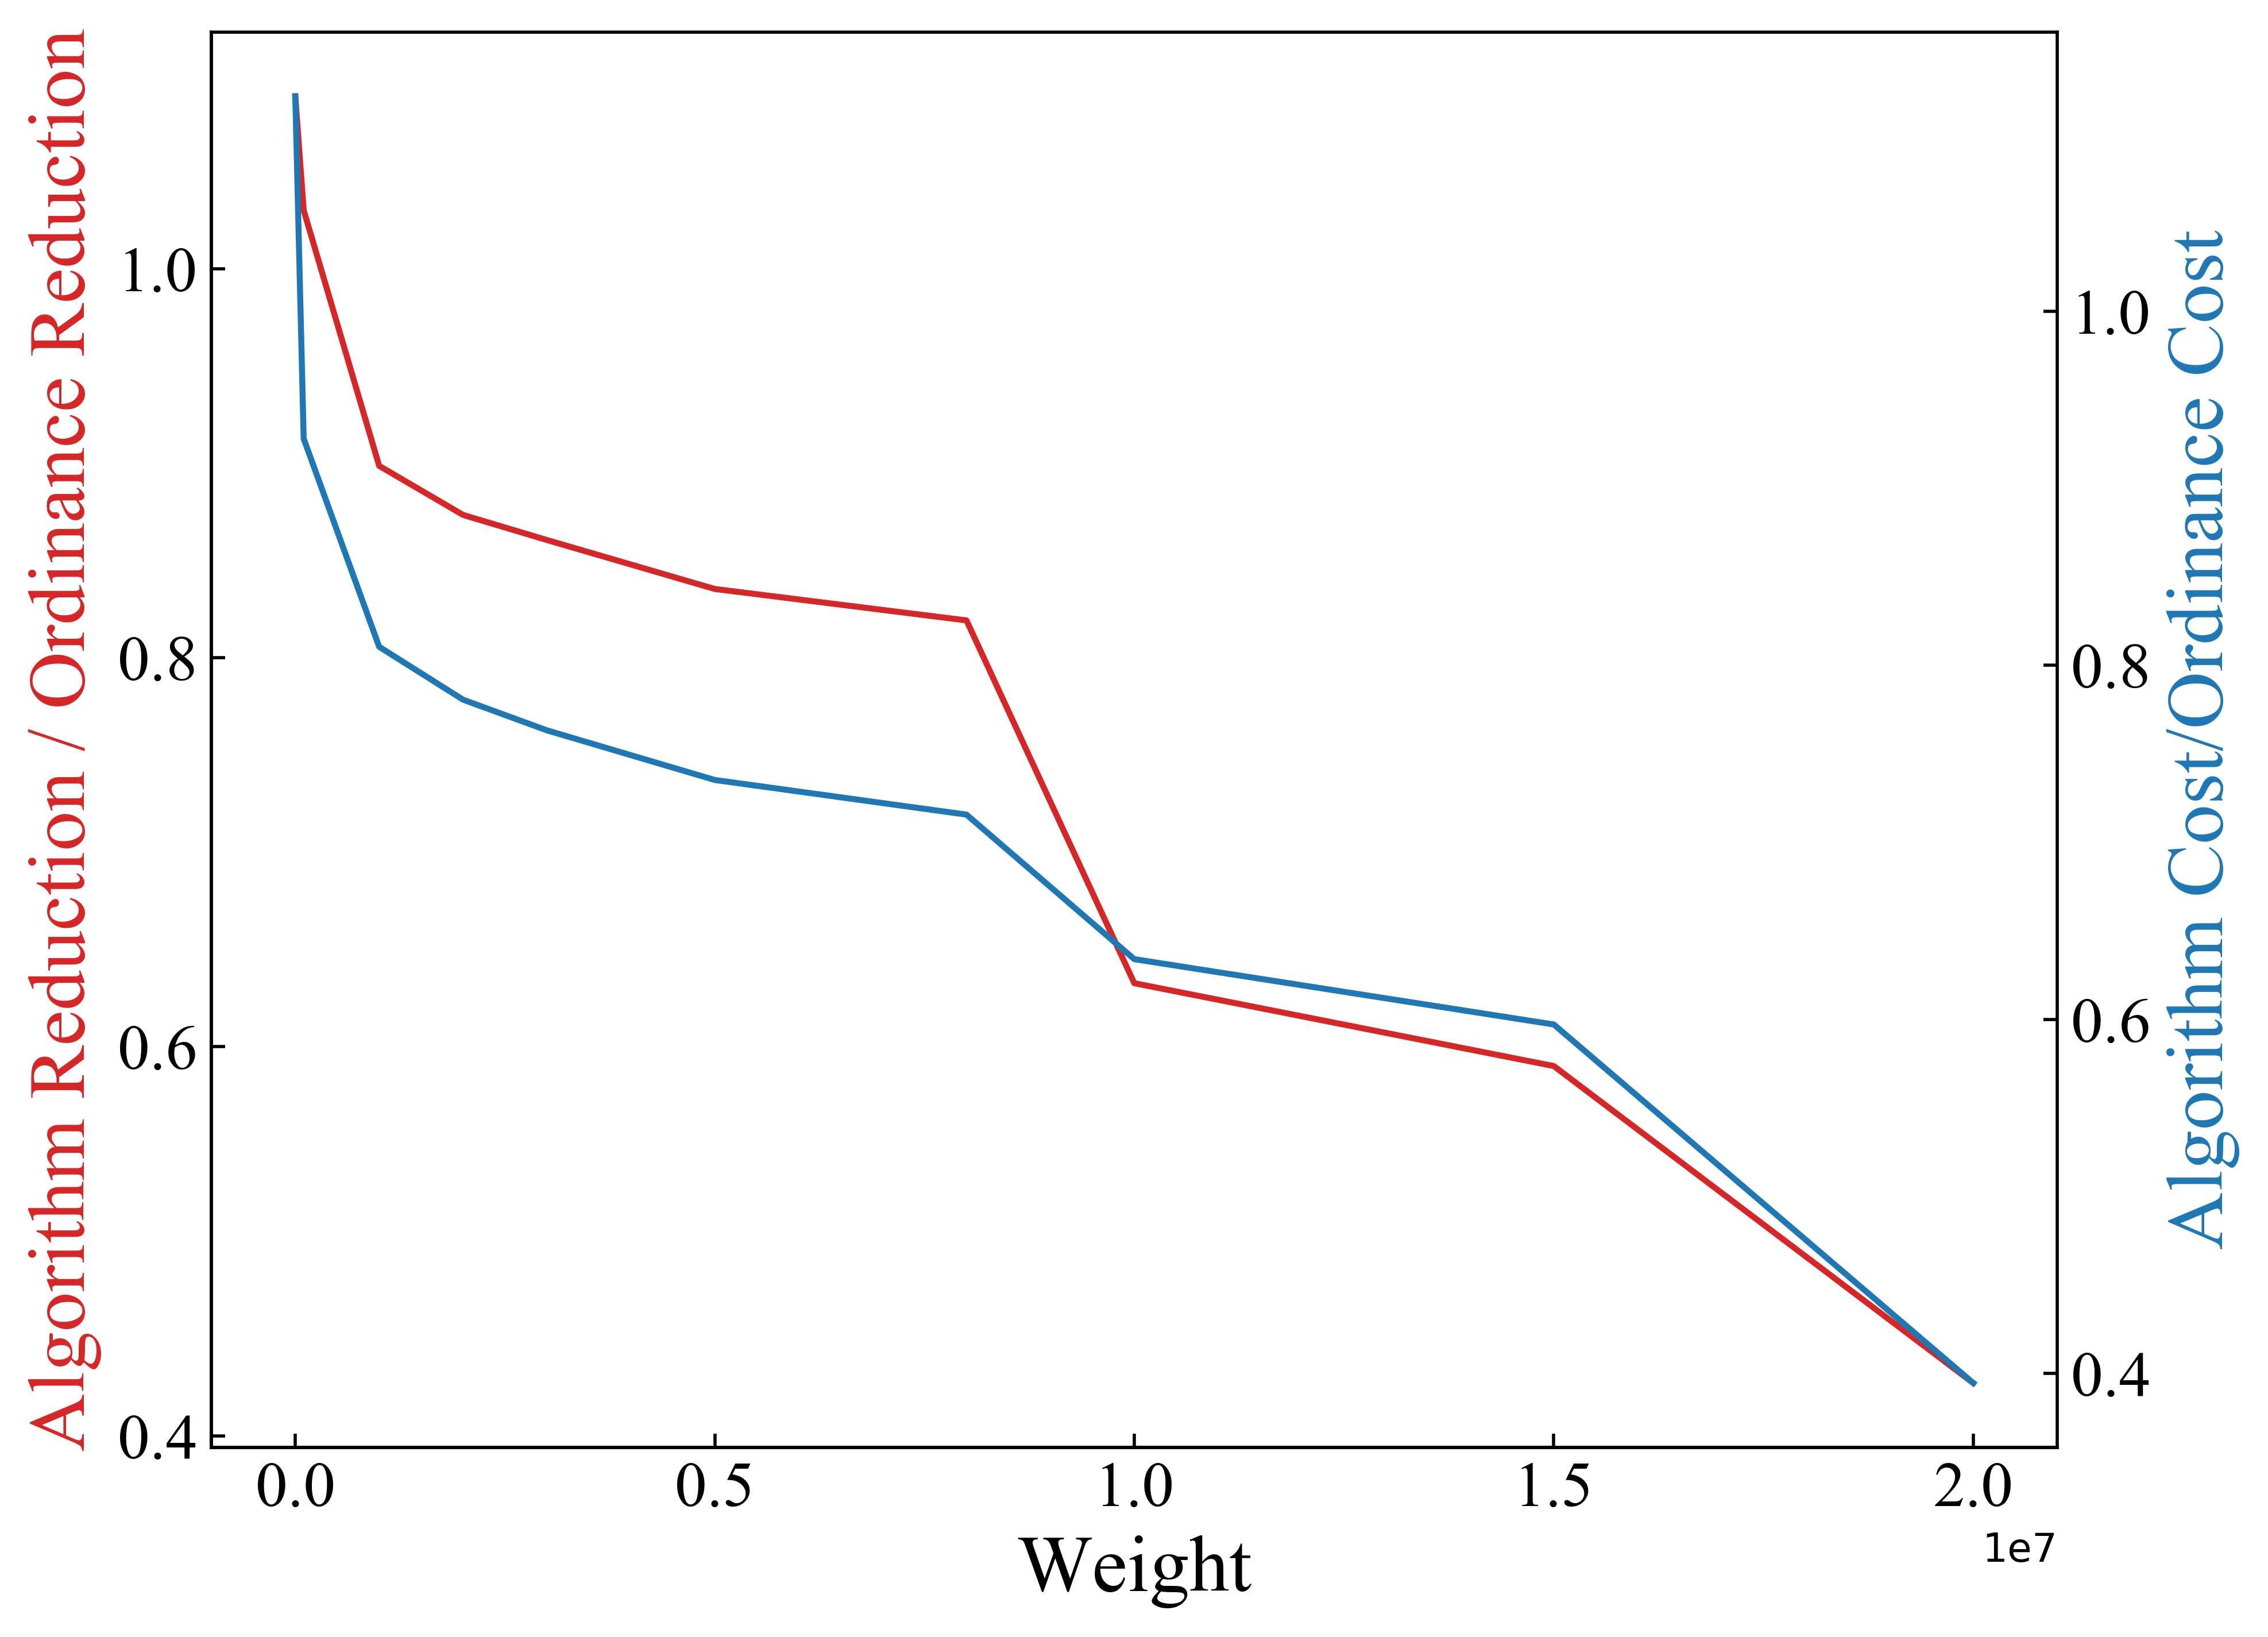

<Figure size 432x288 with 0 Axes>

In [39]:
fig, ax1 = plt.subplots(figsize=(8,6), dpi=500)
font = {'fontname':'Times New Roman', 'size' : 20}

color = 'tab:red'
ax1.set_xlabel('Weight', **font)
ax1.set_ylabel('Algorithm Reduction / Ordinance Reduction', color=color, **font)
ax1.plot(W, [(1-algorithm_loss_sens[i]/Existing_closs)/(1-Ordinance_closs/Existing_closs) for i in range(len(W))], color=color)
sns.despine()
for label in ax1.get_xticklabels():
    label.set_fontproperties('Times New Roman')
for label in ax1.get_yticklabels():
    label.set_fontproperties('Times New Roman')

ax1.tick_params(axis="y",direction="in", labelsize = 16)
ax1.tick_params(axis="x",direction="in", labelsize = 16)
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=4)
 
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(W, [algorithm_cost_sens[i]/Ordinance_cost for i in range(len(W))], color=color)
ax2.tick_params(axis='y', direction = 'in', labelsize = 14)
ax2.set_ylabel('Algorithm Cost/Ordinance Cost', color=color, **font)

for label in ax2.get_yticklabels():
    label.set_fontproperties('Times New Roman')
ax2.tick_params(axis="y",direction="in", labelsize = 16)
plt.locator_params(axis='y', nbins=4)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
sns.despine()

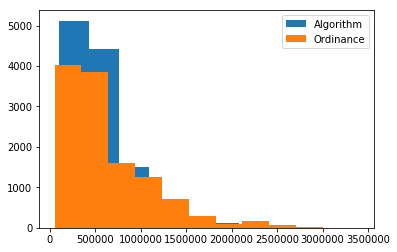

In [33]:
plt.hist(Algorithm_closs_individual['Loss'], label = 'Algorithm')
plt.hist(Ordinance_closs_individual['Loss'], label = 'Ordinance' )
plt.legend()